In [1]:
from dask.distributed import Client, progress
# HPC
# client = Client(scheduler_file='/glade/scratch/jhamman/scheduler.json')
# client

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=10)
cluster

/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [2]:
client = Client(cluster)
client

Client Scheduler: tcp://10.32.60.26:36803 Dashboard: /user/0000-0002-9124-2827/proxy/33193/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

import sys
### general purpose
import os
import xarray as xr
import pandas as pd
### palette
import matplotlib.cm as mplcm
#import matplotlib.cm as cm
#div_cmap = mplcm.seismic
import cmocean
from cmocean import cm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import scipy.io as sio

import time

In [4]:
import gcsfs

fs = gcsfs.GCSFileSystem(project='pangeo-181919', token='anon', access='read_only')
gcs = gcsfs.GCSFileSystem(gcs=fs,check=False,create=False)
gcsmapgrid=gcs.get_mapper('pangeo-data/eNATL60-I/zarr_coord_eNATL60')
dsgrid_eNATL=xr.open_zarr(gcsmapgrid)

In [5]:
lat=dsgrid_eNATL.nav_lat
lon=dsgrid_eNATL.nav_lon

In [6]:
latmin = 42.; latmax = 55.
lonmin = -40.; lonmax = -20.

In [7]:
domain = (lonmin<lon.values) * (lon.values<lonmax) * (latmin<lat.values) * (lat.values<latmax)
where = np.where(domain)
vlats = lat.values[where]
vlons = lon.values[where]
#get indice
jmin = where[0][vlats.argmin()]
jmax = where[0][vlats.argmax()]
imin = where[1][vlons.argmin()]
imax = where[1][vlons.argmax()]
navlon = lon.values[jmin:jmax+1,imin:imax+1]
navlat = lat.values[jmin:jmax+1,imin:imax+1]

In [8]:
fs = gcsfs.GCSFileSystem(project='pangeo-181919', token='anon', access='read_only')
gcs = gcsfs.GCSFileSystem(gcs=fs,check=False,create=False)
mapbathy = gcs.get_mapper('pangeo-data/eNATL60-I/zarr_bathy_eNATL60')
dsbathy = xr.open_zarr(mapbathy)
dsbathy
mapcoord = gcs.get_mapper('pangeo-data/eNATL60-I/zarr_coord_eNATL60')
dscoord=xr.open_zarr(mapcoord)

In [9]:
bathymetry_values=dsbathy.Bathymetry.values[jmin:jmax+1,imin:imax+1]

In [10]:
def plot_surf(sub,data,lon,lat,vmin,vmax,cmap,title,date):
    
    ax = plt.subplot(sub,projection=ccrs.PlateCarree(central_longitude=0))
    land = cfeature.GSHHSFeature(scale='intermediate',
                                 levels=[1],
                                 facecolor=cfeature.COLORS['land'])
    ax.add_feature(land)
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.tick_params('both',labelsize=22)

    plt.pcolormesh(lon,lat,data,cmap=cmap,vmin=vmin,vmax=vmax )
    plt.colorbar(orientation='horizontal',pad=0.1, aspect=50)
    plt.title(title)
    ax.text(0.57, -0.08, date, transform=ax.transAxes)

In [11]:
bathymetry_values.min()

663.58875

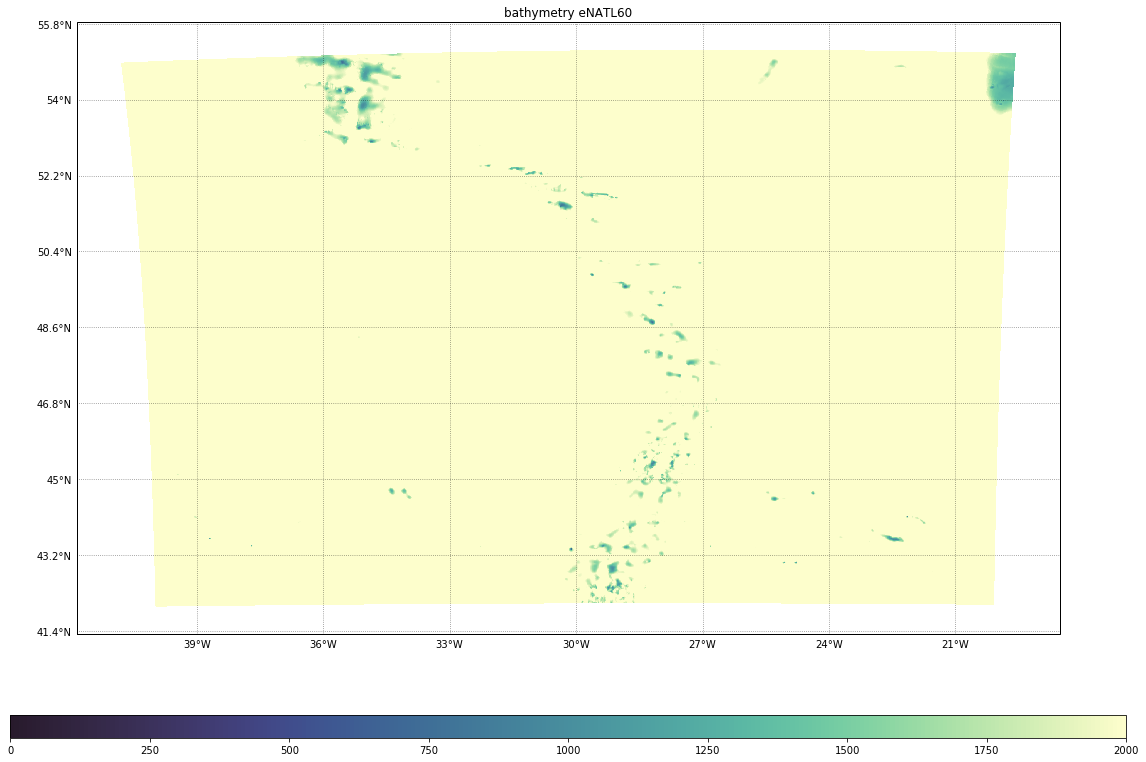

distributed.scheduler - ERROR - Error in reevaluate occupancy
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/psutil/_common.py", line 342, in wrapper
    ret = self._cache[fun]
AttributeError: _cache

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/psutil/_pslinux.py", line 1513, in wrapper
    return fun(self, *args, **kwargs)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/psutil/_common.py", line 345, in wrapper
    return fun(self)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/psutil/_pslinux.py", line 1559, in _parse_stat_file
    with open_binary("%s/%s/stat" % (self._procfs_path, self.pid)) as f:
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/psutil/_common.py", line 587, in open_binary
    return open(fname, "rb", **kwargs)
FileNotFoundError: [Errno 2] No such file or direc

In [13]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.cm as mplcm

lat = dscoord.nav_lat
lon = dscoord.nav_lon
bathy=dsbathy.Bathymetry
fig=plt.figure(figsize=(20,15))
#plot_surf(111,bathy,lon,lat,0,5000,cm.deep_r,'bathymetry eNATL60','')
plot_surf(111,bathymetry_values,navlon,navlat,0,2000,cm.deep_r,'bathymetry eNATL60','')
plt.savefig('Bathymetry_MNA.png')